In [1]:
from datetime import datetime
import string

from arke.cart import merc_map_grid, label_map
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.patches import Rectangle
import numpy as np
import xarray as xr
import xesmf as xe

from common_defs import winters, nyr, datasets, bbox, aliases
import mypaths
from plot_utils import LCC_KW, trans, iletters, div_cmap, use_style

In [2]:
use_style()

In [3]:
zoom_box = [-10, 25, 68, 78]

## Reanalysis data

In [4]:
accacia_pl_datetime = datetime(2013, 3, 26, 12)

In [5]:
dset_dict = dict()
for dataset in datasets:
    dset_dict[dataset] = xr.open_mfdataset(
        getattr(mypaths, f"{dataset}_dir").glob(f"*{accacia_pl_datetime:%Y.%m.}*.nc")
    )

## Satellite scatterometer data

### Load the data

In [6]:
ascat_ds = xr.open_dataset(
    sorted((mypaths.datadir / "obs" / "ACCACIA" / "satellite" / "ASCAT" / "12.5km").glob("*.nc"))[7]
)

In [7]:
ascat_ds = ascat_ds.assign_coords(lon=(((ascat_ds.lon + 180) % 360) - 180))

In [8]:
cond = (
    (ascat_ds.lon >= zoom_box[0])
    & (ascat_ds.lon <= zoom_box[1])
    & (ascat_ds.lat >= zoom_box[2])
    & (ascat_ds.lat <= zoom_box[3])
)

In [9]:
ascat_subset = ascat_ds.where(cond, drop=True)

In [10]:
ascat_dt = ascat_ds.time.values.astype("<M8[us]").astype(datetime)

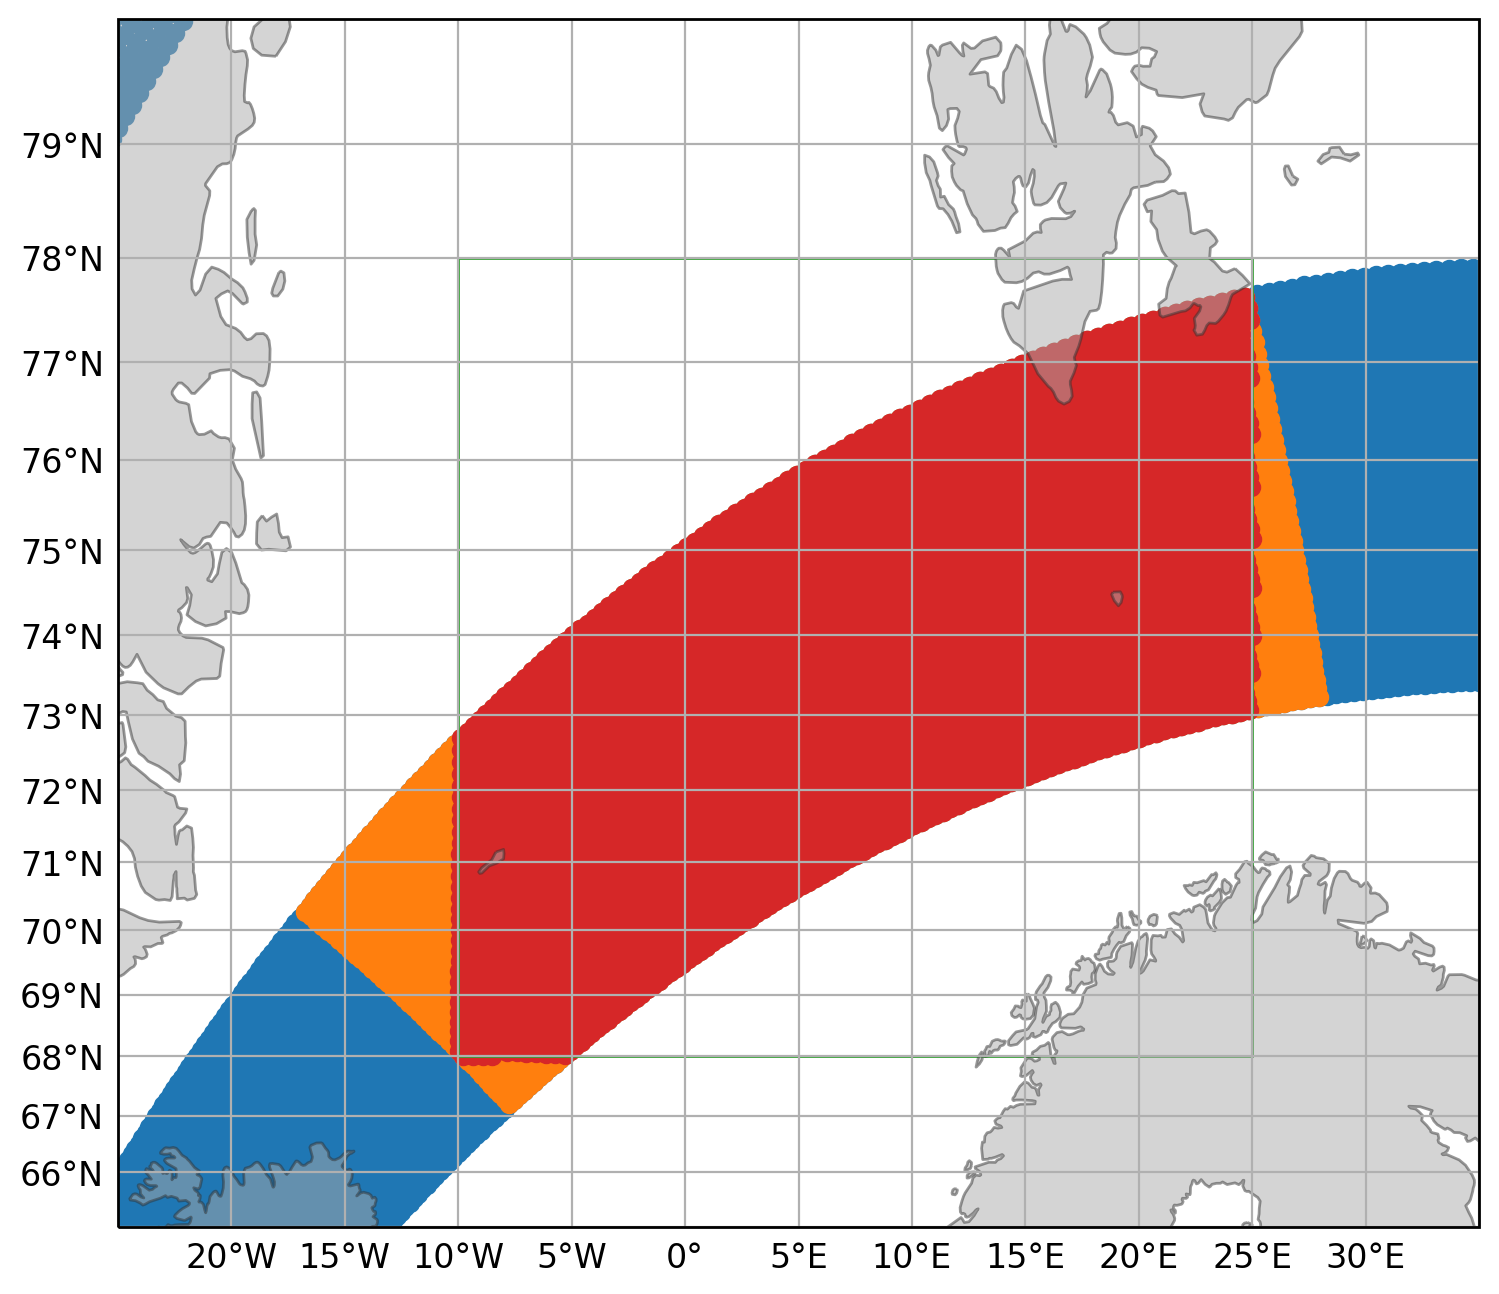

In [11]:
MERC_KW = {k: v for k, v in LCC_KW.items() if not k in ["clon", "clat"]}
MERC_KW["ticks"] = [5, 1]
MERC_KW["extent"] = [-25, 35, 65, 80]

fig = plt.figure(figsize=(12, 8))
axgr = merc_map_grid(fig, (1, 1), **MERC_KW)

ax = axgr.axes_all[0]
# ax.set_global()

ax.scatter(ascat_ds.lon, ascat_ds.lat, **trans)
ax.scatter(ascat_subset.lon.values, ascat_subset.lat.values, c="C1", **trans)
ax.scatter(ascat_ds.lon.values[cond.values], ascat_ds.lat.values[cond.values], c="C3", **trans)
# ax.scatter(ascat_lons[:, :gap_ind+1], ascat_lats[:, :gap_ind+1], **trans)

ax.add_patch(
    Rectangle(
        (zoom_box[0], zoom_box[2]),
        zoom_box[1] - zoom_box[0],
        zoom_box[3] - zoom_box[2],
        linewidth=1,
        edgecolor="C2",
        facecolor="none",
        **trans
    )
)

#### Test that grid spacing is indeed ~12.5 km

In [12]:
a = ascat_subset.wind_speed

In [13]:
from octant.utils import great_circle

In [14]:
# from itertools import product
# l = list(product((-1, 0, 1), repeat=2))
# l.remove((0, 0))

l = [(-1, 0), (0, -1), (0, 1), (1, 0)]

In [15]:
ii, jj = 100, 30
for i, j in l:
    gc = (
        great_circle(
            np.float64(a[ii, jj].lon),
            np.float64(a[ii + j, jj + i].lon),
            np.float64(a[ii, jj].lat),
            np.float64(a[ii + j, jj + i].lat),
        )
        / 1e3
    )
    print(i, j, gc)

-1 0 12.45344677507013
0 -1 12.546881876143212
0 1 12.545114020674601
1 0 12.453051330739438


### Calculate wind components and vorticity

In [16]:
from metpy.calc import vorticity, wind_components
from metpy.units import units
from metpy.xarray import preprocess_xarray

In [17]:
ascat_subset.wind_speed.attrs["units"] = "m s**-1"

In [18]:
u, v = preprocess_xarray(wind_components)(ascat_subset.wind_speed, ascat_subset.wind_dir)

vo = vorticity(u, v, dx=12.5e3, dy=12.5e3)

del u, v

and convert vorticity to the `xarray.DataArray` type

In [19]:
# u = ascat_subset.wind_speed.copy(data=u.magnitude)
# u = u.rename('eastward_wind')
# u.attrs['long_name'] = 'U component of wind'

# v = ascat_subset.wind_speed.copy(data=v.magnitude)
# v = v.rename('northward_wind')
# v.attrs['long_name'] = 'V component of wind'

In [20]:
vo = ascat_subset.wind_speed.copy(data=vo.magnitude)
vo = vo.rename("relative_vorticity")
vo.attrs["long_name"] = "Vorticity (relative)"
vo.attrs["units"] = "s**-1"

### Regrid to a regular lon-lat grid

define a grid onto which to interpolate the data

In [21]:
_dx = 0.1  # for simplicity, the same as in ERA5
target_grid_ds = xe.util.grid_2d(
    zoom_box[0] - _dx / 2, zoom_box[1], _dx, zoom_box[2] - _dx / 2, zoom_box[3], _dx
)

In [22]:
regridder = xe.Regridder(ascat_subset, target_grid_ds, "bilinear", reuse_weights=False)

Overwrite existing file: bilinear_118x41_101x351.nc 
 You can set reuse_weights=True to save computing time.


In [23]:
_xr_dict = {}
for varname, ascat_var in (("vo", vo), ("wspd", ascat_subset.wind_speed)):
    _xr_dict[varname] = regridder(ascat_var)
    _xr_dict[varname].attrs.update(ascat_var.attrs)
ascat_ds_regr = xr.Dataset(_xr_dict).rename({"y": "latitude", "x": "longitude"})

ascat_ds_regr = ascat_ds_regr.assign_coords(
    longitude=ascat_ds_regr.lon.values[0, :], latitude=ascat_ds_regr.lat.values[:, 0]
).drop(["lon", "lat"])

In [24]:
AXGR_KW = dict(axes_pad=0.55, cbar_location="right", cbar_mode="edge", cbar_pad=0.2, cbar_size="3%")

In [25]:
MERC_KW = {k: v for k, v in LCC_KW.items() if not k in ["clon", "clat"]}
MERC_KW["ticks"] = [5, 1]
MERC_KW["extent"] = [-10, 25, 68, 78]
text_kw = dict(
    ha="center",
    va="center",
    fontsize="medium",
    path_effects=[PathEffects.withStroke(linewidth=3, foreground="w")],
)

In [26]:
_toponyms = [
    dict(name="Svalbard", lon=15, lat=77.5),
    dict(name="Norway", lon=17, lat=69),
    dict(name="Fram\nStrait", lon=0, lat=77),
    dict(name="Norwegian\nSea", lon=5, lat=68.75),
]

In [27]:
wspd_kw = dict(
    add_colorbar=False, add_labels=False, levels=np.arange(6, 27, 3), cmap="Oranges", extend="max"
)
vo_kw = dict(
    levels=[-2, -0.2, 0.2, 2],
    cmap="PuOr_r",
    extend="both",
    add_colorbar=False,
    rasterized=True,
    add_labels=False,
)
vo_scale = 1e4
slp_kw = dict(
    add_colorbar=False, add_labels=False, colors="r", linewidths=0.5, levels=np.arange(800, 1100, 2)
)

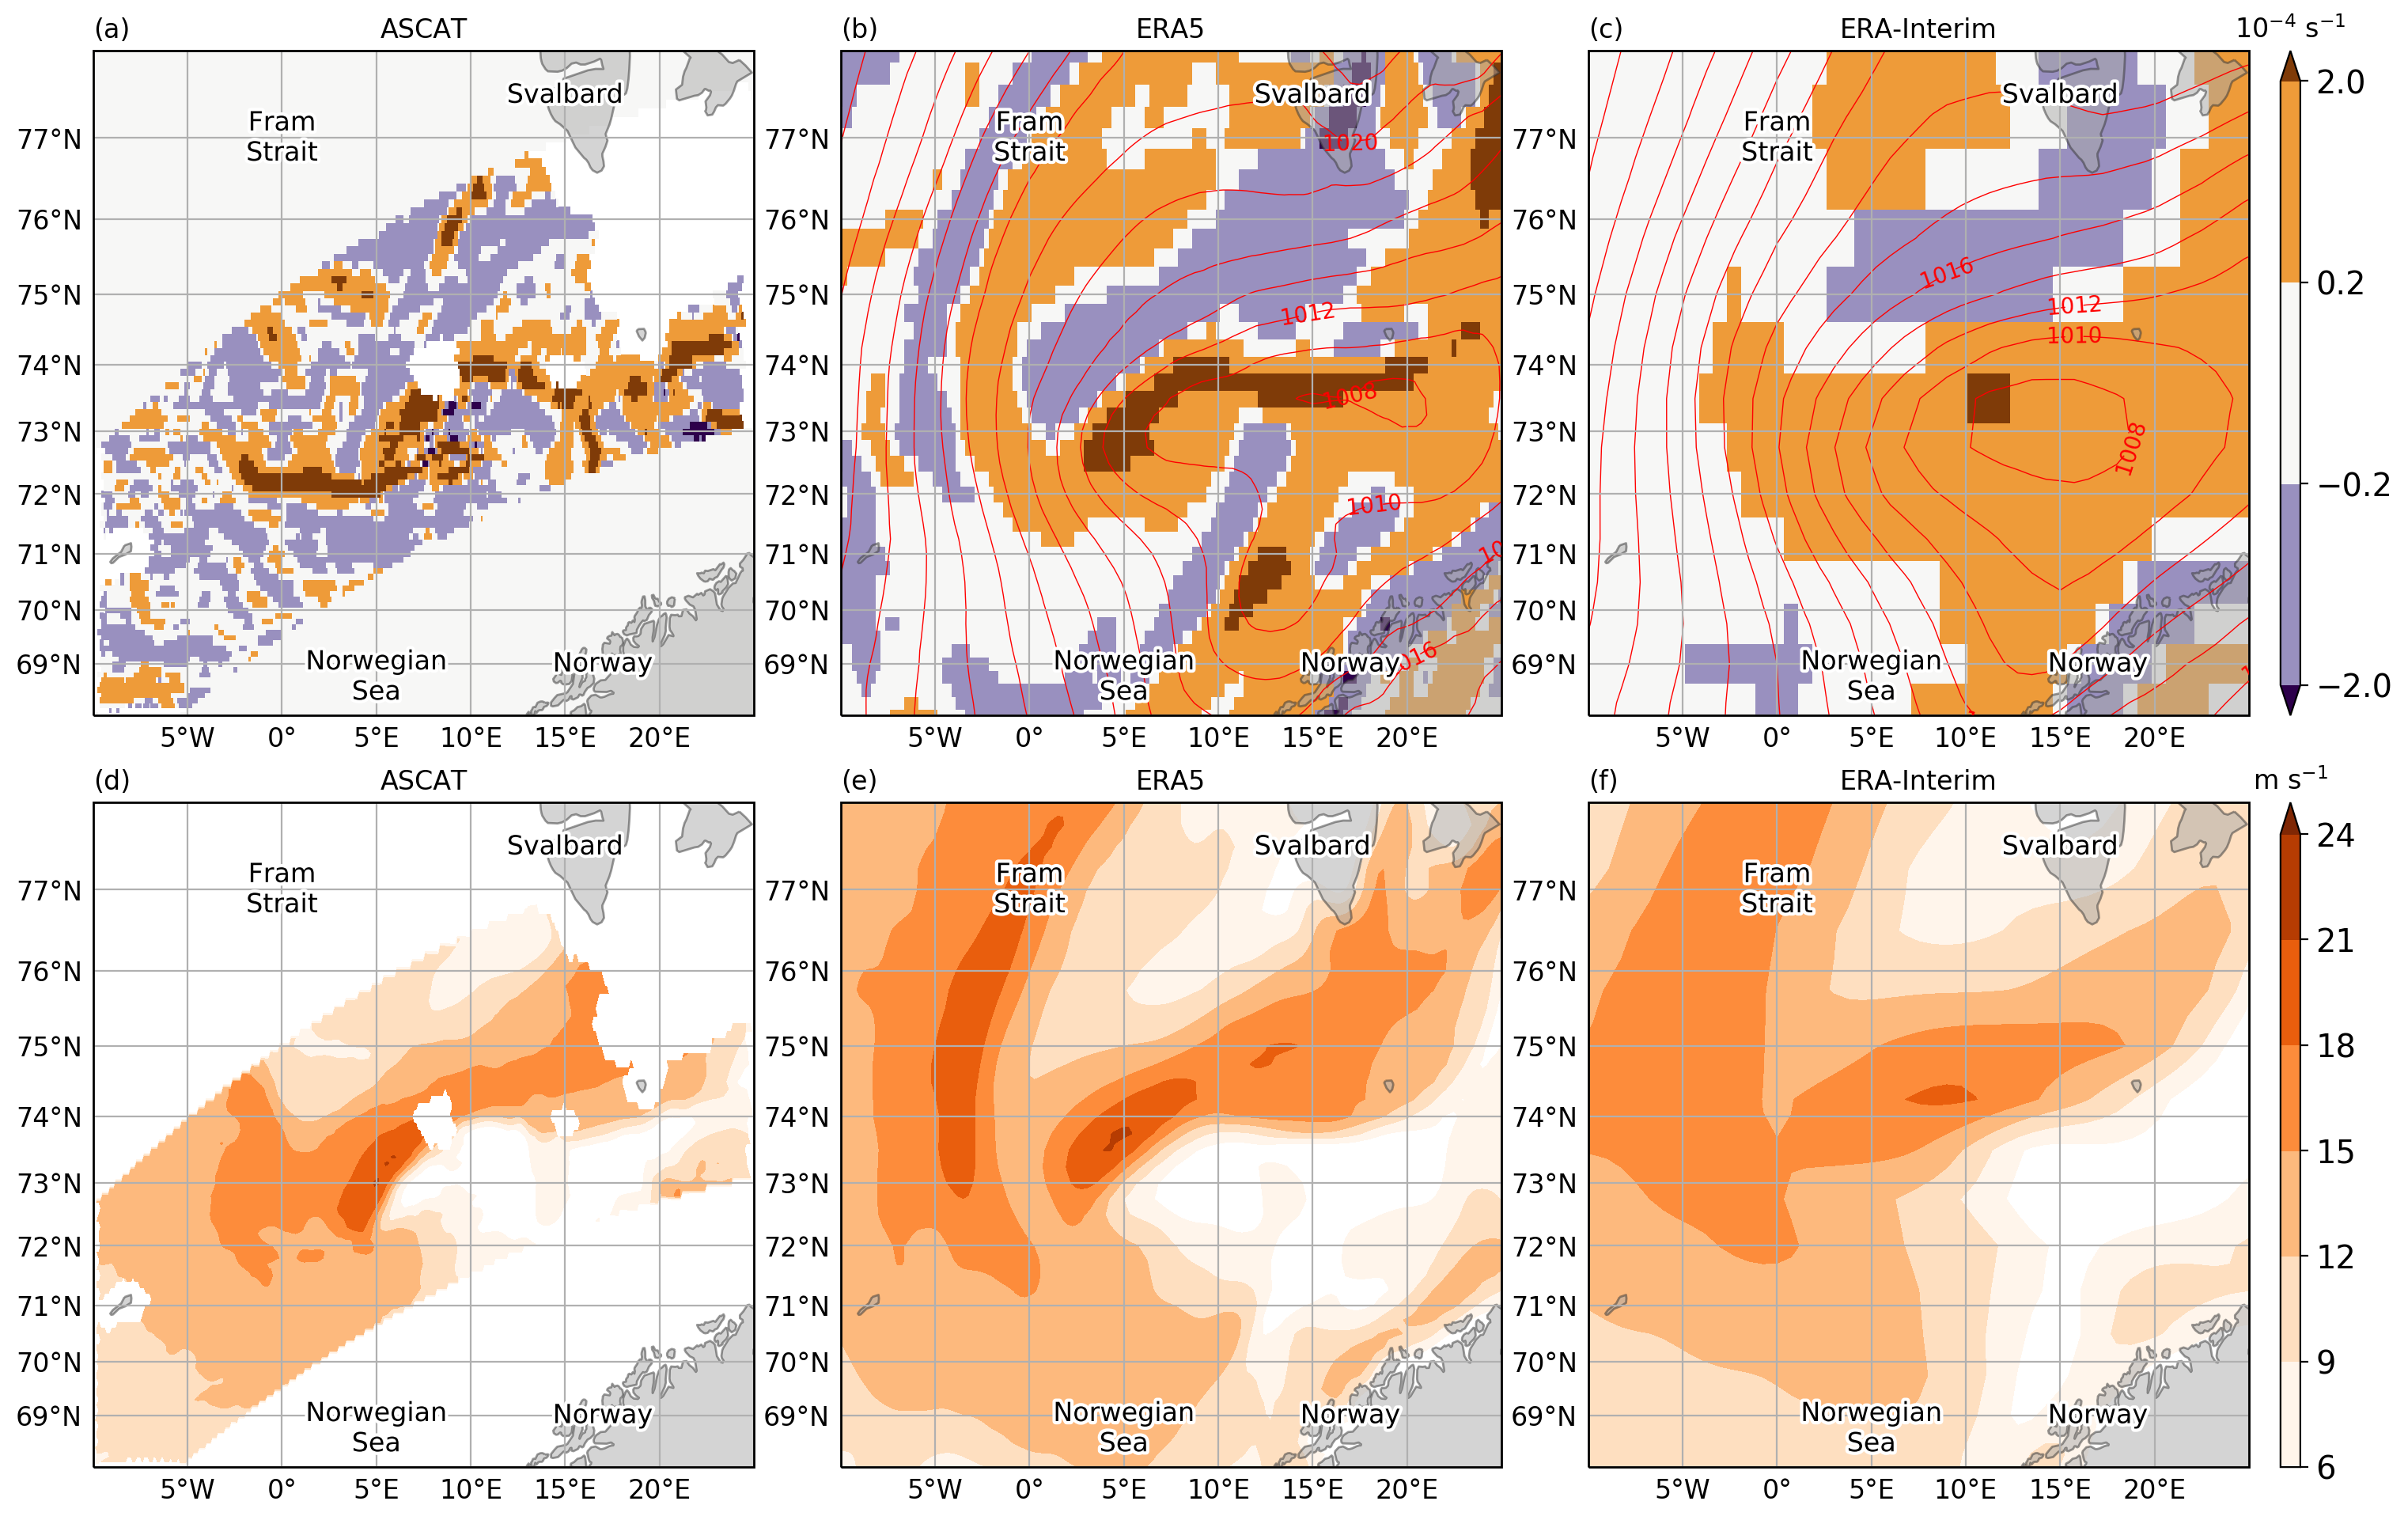

In [28]:
ncol = len(datasets) + 1
nrow = 2

iletters = iter(string.ascii_lowercase)

fig = plt.figure(figsize=(ncol * 6, nrow * 6))
axgr = merc_map_grid(fig, (nrow, ncol), **MERC_KW, **AXGR_KW)

for ax in axgr.axes_all:
    ax.set_title(f"({next(iletters)})", loc="left", fontsize="medium")

# Vorticity and sea-level pressure
# ASCAT data in the leftmost column
ax = axgr.axes_row[0][0]
ax.set_title("ASCAT", loc="center", fontsize="medium")
(ascat_ds_regr.vo * vo_scale).plot.pcolormesh(ax=ax, **trans, **vo_kw)

for ax, dataset in zip(axgr.axes_row[0][1:], datasets):
    vort = (dset_dict[dataset].vo.sel(time=accacia_pl_datetime, level=950) * vo_scale)[::-1, :]
    slp = (dset_dict[dataset].msl.sel(time=accacia_pl_datetime) * 1e-2)[::-1, :]
    h0 = vort.plot.pcolormesh(ax=ax, **trans, **vo_kw)

    c = slp.plot.contour(ax=ax, **trans, **slp_kw)
    ax.clabel(c, fmt="%4.0f", colors=slp_kw["colors"], fontsize="small")
    ax.set_title(aliases[dataset], loc="center", fontsize="medium")

# Wind speed
# ASCAT data in the leftmost column
ax = axgr.axes_row[1][0]
ax.set_title("ASCAT", loc="center", fontsize="medium")
ascat_ds_regr.wspd.plot.contourf(ax=ax, **trans, **wspd_kw)

for ax, dataset in zip(axgr.axes_row[1][1:], datasets):
    u = dset_dict[dataset].u.sel(time=accacia_pl_datetime, level=1000)[::-1, :]
    v = dset_dict[dataset].v.sel(time=accacia_pl_datetime, level=1000)[::-1, :]
    wspd = (u ** 2 + v ** 2) ** 0.5
    h1 = wspd.plot.contourf(ax=ax, **trans, **wspd_kw)
    ax.set_title(aliases[dataset], loc="center", fontsize="medium")

#     if dataset == 'era5':
#         xstride = 1
#         ystride = 1
#     else:
#         xstride = 1
#         ystride = 1
#     p = ax.quiver(u.longitude[::xstride], u.latitude[::ystride],
#                   u.values[::ystride, ::xstride], v.values[::ystride, ::xstride], scale=300, **trans)

cb = fig.colorbar(h0, cax=axgr.cbar_axes[0])
cb.ax.set_title("$10^{-4}$ $s^{-1}$", fontsize="medium")
cb.ax.tick_params(labelsize="large")
cb = fig.colorbar(h1, cax=axgr.cbar_axes[1])
cb.ax.set_title("$m$ $s^{-1}$", fontsize="medium")
cb.ax.tick_params(labelsize="large")

for ax in axgr:
    label_map(ax, _toponyms, **trans, **text_kw)
    ax.tick_params(labelsize="xx-small")

In [29]:
fig.savefig(mypaths.plotdir / "ascat_era5_interim_accacia_case_vort_wspd")